In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, course_cross_validate, Course_GridSearchCV

import pickle

import warnings

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns',None)

In [2]:
df = load_OU_data(prediction_window=.5)
df.drop(columns = ['id_student','code_presentation','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration'], inplace = True)
if 'date_unregistration' in df.columns:
    df.drop(columns = ['date_unregistration'], inplace = True)
df.head()

,code_module,num_of_prev_attempts,final_result,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,0,Pass,26.0,121.0,628.0,3.0,81.000000
1,AAA,0,Pass,45.0,266.0,896.0,2.0,69.000000
2,AAA,0,Pass,68.0,371.0,1231.0,3.0,72.333333
3,AAA,0,Pass,40.0,207.0,747.0,2.0,49.500000
4,AAA,0,Pass,70.0,365.0,1271.0,3.0,74.000000


In [16]:
X = df.drop(columns = ['final_result'])
y = df['final_result']

binary_y = np.array(['No Intervention' if label in ['Distinction','Pass'] 
            else 'Needs Intervention' for label in y])

#Check the class balance
display(np.unique(binary_y,return_counts=True))

cv = KFold(n_splits = 5, shuffle = True, random_state = 111)


X_train, X_test, y_train, y_test = train_test_split(X, binary_y, random_state=111, test_size=0.2)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111, test_size=0.2)

X_train_transformed, y_train_transformed, X_test_transformed = process_courses(X_train, y_train, X_test)

(array(['Needs Intervention', 'No Intervention'], dtype='<U18'),
 array([ 9211, 14654], dtype=int64))

In [17]:
final_model = pickle.load(open('../models/RFmodel2.pkl','rb'))

final_model.fit(X_train_transformed, y_train_transformed)
y_predRF = final_model.predict(X_test_transformed)
print('Final Model')
print(final_model)
print('Final Model Classification Report')
print(classification_report(y_test, y_pred))
print('Final Model Confusion Matrix')

Final Model
RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_split=5,
                       n_estimators=150, n_jobs=-1, random_state=111)
Final Model Classification Report
                    precision    recall  f1-score   support

Needs Intervention       0.70      0.71      0.70      1804
   No Intervention       0.82      0.81      0.82      2969

          accuracy                           0.77      4773
         macro avg       0.76      0.76      0.76      4773
      weighted avg       0.78      0.77      0.77      4773

Final Model Confusion Matrix


In [18]:
final_model = pickle.load(open('../models/XGBmodel4.pkl','rb'))

final_model.fit(X_train_transformed, y_train_transformed)
y_predXGB = final_model.predict(X_test_transformed)
print('Final Model')
print(final_model)
print('Final Model Classification Report')
print(classification_report(y_test, y_pred))
print('Final Model Confusion Matrix')

Final Model
XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=2, random_state=111, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)
Final Model Classification Report
                    precision    recall  f1-score   support

Needs Intervention       0.70      0.71      0.70      1804
   No Intervention       0.82      0.81      0.82      2969

          accuracy                           0.77      4773
         macro avg       0.76      0.76      0.76      4773
      weighted avg       0.78     

In [31]:
evaluation = X_test.copy()
evaluation['result'] = y_test
evaluation['RF'] = y_predRF
evaluation['XGB'] = y_predXGB

In [35]:
print('same_guesses', len(evaluation[evaluation['RF'] == evaluation['XGB']]))
print('different_guesses', len(evaluation[evaluation['RF'] != evaluation['XGB']]))

same_guesses 4379
different_guesses 394


In [33]:
evaluation.head()

,code_module,num_of_prev_attempts,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score,result,RF,XGB
0,CCC,0,6.0,12.0,21.0,0.0,0.000000,Needs Intervention,Needs Intervention,Needs Intervention
1,DDD,1,3.0,9.0,30.0,0.0,0.000000,Needs Intervention,Needs Intervention,Needs Intervention
2,DDD,0,48.0,204.0,452.0,4.0,80.000000,No Intervention,No Intervention,No Intervention
3,FFF,1,57.0,440.0,1962.0,3.0,84.666667,No Intervention,No Intervention,No Intervention
4,CCC,0,26.0,166.0,395.0,3.0,70.000000,Needs Intervention,Needs Intervention,Needs Intervention


In [36]:
XGBcorrect = evaluation[evaluation['result'] == evaluation['XGB']]
RFcorrect = evaluation[evaluation['result'] == evaluation['RF']]
display(XGBcorrect)

,code_module,num_of_prev_attempts,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score,result,RF,XGB
0,CCC,0,6.0,12.0,21.0,0.0,0.000000,Needs Intervention,Needs Intervention,Needs Intervention
1,DDD,1,3.0,9.0,30.0,0.0,0.000000,Needs Intervention,Needs Intervention,Needs Intervention
2,DDD,0,48.0,204.0,452.0,4.0,80.000000,No Intervention,No Intervention,No Intervention
3,FFF,1,57.0,440.0,1962.0,3.0,84.666667,No Intervention,No Intervention,No Intervention
4,CCC,0,26.0,166.0,395.0,3.0,70.000000,Needs Intervention,Needs Intervention,Needs Intervention
...,...,...,...,...,...,...,...,...,...,...
4767,GGG,0,11.0,43.0,113.0,2.0,88.000000,No Intervention,No Intervention,No Intervention
4768,GGG,0,8.0,30.0,76.0,2.0,77.500000,No Intervention,No Intervention,No Intervention
4769,BBB,0,57.0,145.0,301.0,6.0,79.666667,No Intervention,No Intervention,No Intervention
4771,DDD,0,6.0,52.0,144.0,0.0,0.000000,Needs Intervention,Needs Intervention,Needs Intervention


# Feature Importance

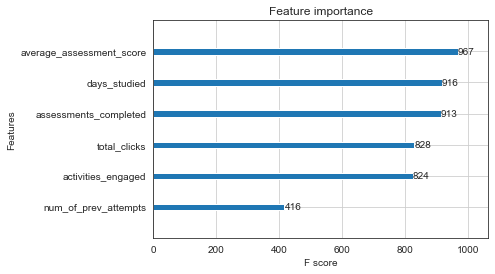

In [38]:
from xgboost import plot_importance

plot_importance(final_model)
plt.savefig('../figures/XGB_final_model_feature_importance.png')

# Statistics of XGB predicted 'No Intervention

In [47]:
evaluation[evaluation['XGB'] == 'No Intervention'].describe()

,num_of_prev_attempts,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
count,2857.000000,2857.000000,2857.000000,2857.000000,2857.000000,2857.000000
mean,0.095205,50.957998,310.094505,1115.744837,4.013651,82.200197
std,0.388068,28.181739,231.950752,1099.753428,1.597712,9.196610
min,0.000000,0.000000,0.000000,0.000000,1.000000,33.666667
25%,0.000000,29.000000,142.000000,404.000000,3.000000,77.000000
50%,0.000000,47.000000,250.000000,769.000000,4.000000,83.000000
75%,0.000000,69.000000,413.000000,1449.000000,5.000000,88.666667
max,5.000000,140.000000,1600.000000,8988.000000,11.000000,100.000000


In [49]:
evaluation[evaluation['result'] == 'No Intervention'].describe()

,num_of_prev_attempts,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
count,2969.000000,2969.000000,2969.00000,2969.000000,2969.00000,2969.000000
mean,0.110475,47.901314,290.75682,1040.281239,3.91647,79.372828
std,0.399530,28.877367,233.81138,1086.299513,1.62582,12.223783
min,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
25%,0.000000,25.000000,120.00000,342.000000,3.00000,73.666667
50%,0.000000,43.000000,224.00000,686.000000,4.00000,81.333333
75%,0.000000,67.000000,392.00000,1350.000000,5.00000,87.833333
max,5.000000,140.000000,1600.00000,8988.000000,11.00000,100.000000


In [51]:
evaluation[evaluation['result'] == 'Needs Intervention'].describe()

,num_of_prev_attempts,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
count,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000
mean,0.236142,25.488359,144.282151,481.951774,2.504989,55.051443
std,0.598298,22.388304,150.264085,649.253322,1.843722,29.560466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,39.000000,98.000000,1.000000,40.687500
50%,0.000000,20.000000,99.000000,287.500000,2.000000,65.000000
75%,0.000000,37.000000,199.000000,624.500000,4.000000,77.000000
max,6.000000,125.000000,1072.000000,7896.000000,10.000000,100.000000


In [64]:
evaluation[(evaluation['result'] != evaluation['XGB'])].describe()

,num_of_prev_attempts,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,0.194779,34.210843,194.653614,655.102410,3.474900,71.235864
std,0.513352,23.728738,167.339247,737.174583,1.544116,13.863929
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,76.000000,202.500000,3.000000,64.950000
50%,0.000000,29.000000,147.500000,425.000000,3.000000,72.833333
75%,0.000000,47.000000,256.250000,855.000000,4.000000,80.666667
max,5.000000,125.000000,1095.000000,7896.000000,10.000000,100.000000


# Statistics of XGB predicted 'Needs Intervention'

In [48]:
evaluation[evaluation['XGB'] == 'Needs Intervention'].describe()

,num_of_prev_attempts,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
count,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000
mean,0.251566,22.240605,124.009395,402.063152,2.442589,52.257186
std,0.595345,19.502722,132.599304,547.412867,1.783107,27.163112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,36.000000,85.750000,1.000000,42.437500
50%,0.000000,18.000000,86.000000,245.000000,2.000000,61.000000
75%,0.000000,32.000000,169.000000,507.000000,3.000000,70.333333
max,6.000000,125.000000,1095.000000,6803.000000,10.000000,100.000000


In [53]:
evaluation.head()

,code_module,num_of_prev_attempts,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score,result,RF,XGB
0,CCC,0,6.0,12.0,21.0,0.0,0.000000,Needs Intervention,Needs Intervention,Needs Intervention
1,DDD,1,3.0,9.0,30.0,0.0,0.000000,Needs Intervention,Needs Intervention,Needs Intervention
2,DDD,0,48.0,204.0,452.0,4.0,80.000000,No Intervention,No Intervention,No Intervention
3,FFF,1,57.0,440.0,1962.0,3.0,84.666667,No Intervention,No Intervention,No Intervention
4,CCC,0,26.0,166.0,395.0,3.0,70.000000,Needs Intervention,Needs Intervention,Needs Intervention


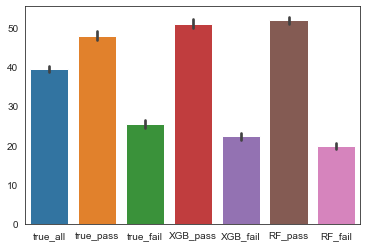

In [63]:
sns.barplot(data=eval_days_studied)

In [61]:
evaluation[evaluation['XGB'] == 'Needs Intervention']['days_studied']

Series([], Name: days_studied, dtype: float64)

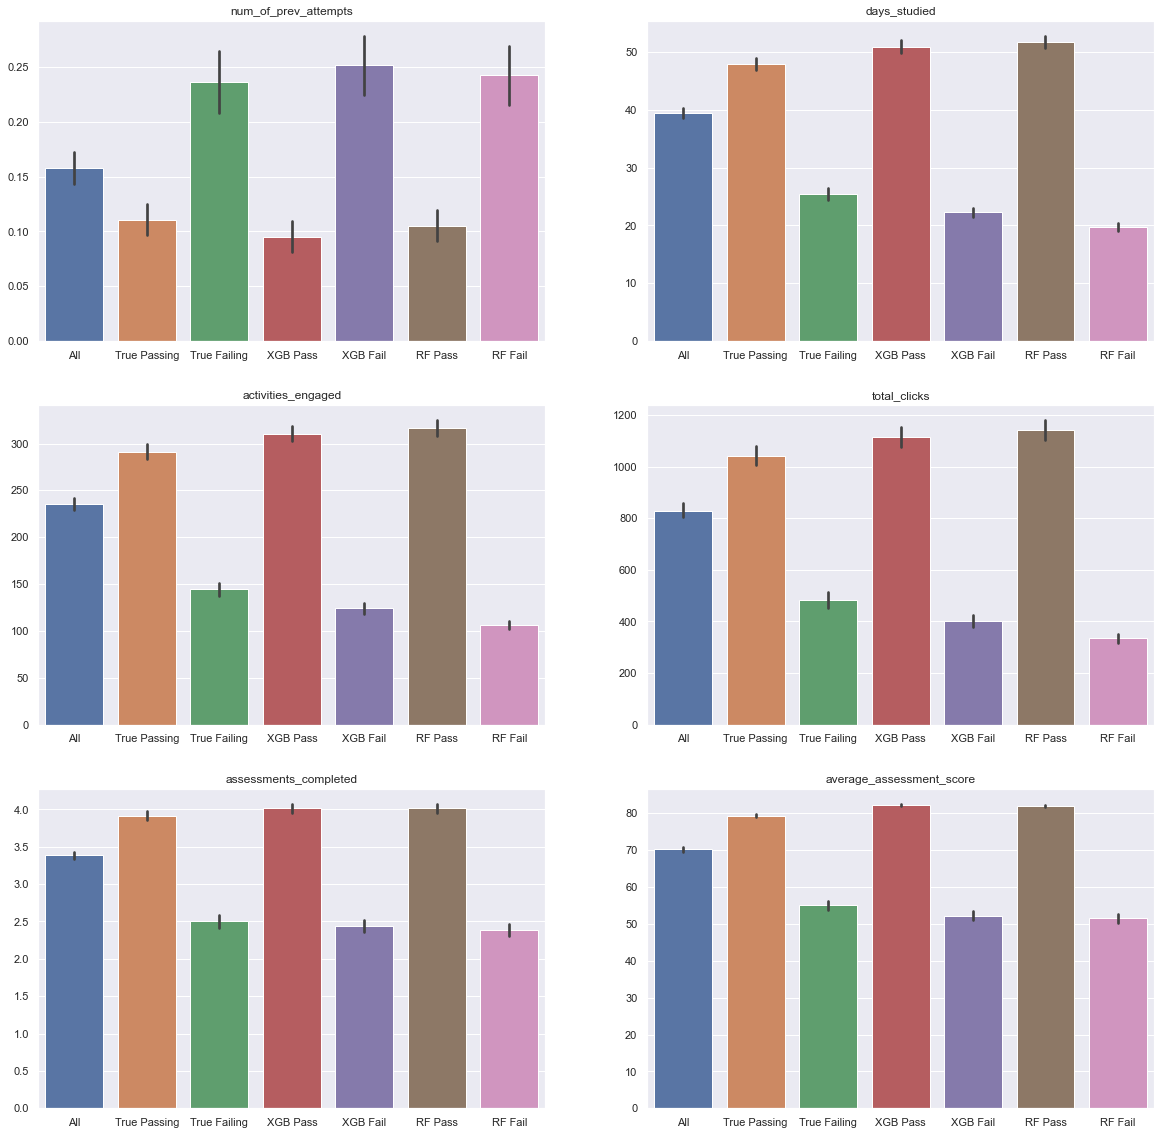

In [86]:
sns.set(font_scale=1)
fig, axes = plt.subplots(3,2, figsize = (20,20))
axes = axes.ravel()
for i, column in enumerate(X_test.columns[1:]):
    to_graph = pd.DataFrame()
    to_graph['All'] = evaluation[column]
    to_graph['True Passing'] = evaluation[evaluation['result'] == 'No Intervention'][column]
    to_graph['True Failing'] = evaluation[evaluation['result'] == 'Needs Intervention'][column]
    to_graph['XGB Pass'] = evaluation[evaluation['XGB'] == 'No Intervention'][column]
    to_graph['XGB Fail'] = evaluation[evaluation['XGB'] == 'Needs Intervention'][column]
    to_graph['RF Pass']  = evaluation[evaluation['RF'] == 'No Intervention'][column]
    to_graph['RF Fail']  = evaluation[evaluation['RF'] == 'Needs Intervention'][column]
    sns.barplot(data = to_graph, ax = axes[i])
    axes[i].set(title=column)